In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [23]:
class TCALoss(nn.Module):
    def __init__(self, lambda_reg=0.01):
        super(TCALoss, self).__init__()
        self.lambda_reg = lambda_reg
    
    def forward(self, X, Y, Z, Delta_X):
        # Compute perturbed X
        X_prime = X + Delta_X
        
        # TCA error variance for X'
        tca_error = torch.mean((X_prime - (Y + Z - X_prime) / 2) ** 2)
        
        # Regularization term to limit the perturbation
        reg_term = self.lambda_reg * torch.mean(Delta_X ** 2)
        
        # Total loss
        loss = tca_error + reg_term
        return loss

In [36]:
class UNet1D(nn.Module):
    def __init__(self, in_channels, out_channels, features=[64, 128, 256, 512]):
        super(UNet1D, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Downward path (Encoder)
        for feature in features:
            self.encoder.append(self._block(in_channels, feature))
            in_channels = feature

        # Upward path (Decoder)
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose1d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(self._block(feature * 2, feature))

        # Bottleneck layer
        self.bottleneck = self._block(features[-1], features[-1] * 2)

        # Final convolution
        self.final_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder part
        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        # Decoder part
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx + 1](concat_skip)

        return self.final_conv(x)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

In [37]:
# Simple Fully Connected Model
class SimplePerturbationModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimplePerturbationModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# CNN-Based Model
class CNNPerturbationModel(nn.Module):
    def __init__(self, input_dim, output_dim, num_filters=16, kernel_size=3):
        super(CNNPerturbationModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.fc = nn.Linear(num_filters * input_dim, output_dim)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension for CNN
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)
        return x

# LSTM-Based Model
class LSTMPerturbationModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(LSTMPerturbationModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden and cell state
        h0 = torch.zeros(2, x.size(0), hidden_dim).to(x.device)
        c0 = torch.zeros(2, x.size(0), hidden_dim).to(x.device)
        
        # Forward propagate the LSTM
        out, _ = self.lstm(x.unsqueeze(-1), (h0, c0))
        
        # Output layer
        out = self.fc(out[:, -1, :])  # We take the last hidden state as output
        return out

class DiffusionModel(nn.Module):
    def __init__(self, model, timesteps, beta_start, beta_end):
        super(DiffusionModel, self).__init__()
        self.model = model
        self.timesteps = timesteps
        self.beta_schedule = torch.linspace(beta_start, beta_end, timesteps)
        
    def forward_diffusion(self, x, t):
        noise = torch.randn_like(x)
        beta_t = self.beta_schedule[t]
        return torch.sqrt(1 - beta_t) * x + torch.sqrt(beta_t) * noise, noise

    def reverse_diffusion(self, x_noisy):
        return self.model(x_noisy)  # Remove t, just pass x_noisy

    def train(self, X, Y, Z, num_epochs=100):
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        loss_function = TCALoss(lambda_reg=0.01)
        
        for epoch in range(num_epochs):
            for t in reversed(range(self.timesteps)):
                x_noisy, noise = self.forward_diffusion(X, t)
                x_pred = self.reverse_diffusion(x_noisy)
                loss = loss_function(X, Y, Z, x_pred)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Final output after training
        return self.model(X)

In [41]:
# Generating toy data
np.random.seed(42)
torch.manual_seed(42)

# Assume we have 100 data points, each with a single time series of length 50
N = 100
time_length = 50

# True signal
true_signal = np.sin(np.linspace(0, 10, time_length))

# Generate X, Y, Z with added random noise
X = true_signal + np.random.normal(0, 0.5, size=(N, time_length))
Y = true_signal + np.random.normal(0, 0.5, size=(N, time_length))
Z = true_signal + np.random.normal(0, 0.5, size=(N, time_length))

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)
Z_tensor = torch.tensor(Z, dtype=torch.float32)

# Reshape tensors for U-Net input
X_tensor_reshaped = X_tensor.unsqueeze(1)
Y_tensor_reshaped = Y_tensor.unsqueeze(1)
Z_tensor_reshaped = Z_tensor.unsqueeze(1)

In [ ]:
# Define and train the diffusion model
timesteps = 1000
unet_model = UNet1D(in_channels=1, out_channels=1)
diffusion_model = DiffusionModel(model=unet_model, timesteps=timesteps, beta_start=0.1, beta_end=0.02)

# Train the diffusion model
perturbed_X = diffusion_model.train(X_tensor_reshaped, Y_tensor_reshaped, Z_tensor_reshaped)

# Reshape the perturbed X back for comparison
perturbed_X = perturbed_X.squeeze(1)

In [25]:
def train_model(model, X_tensor, Y_tensor, Z_tensor, num_epochs=100, learning_rate=0.001):
    # Initialize the loss function and optimizer
    loss_function = TCALoss(lambda_reg=0.01)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(num_epochs):
        # Forward pass: compute the perturbation
        Delta_X_pred = model(X_tensor)
        
        # Compute loss
        loss = loss_function(X_tensor, Y_tensor, Z_tensor, Delta_X_pred)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Return the final perturbed X
    return X_tensor + model(X_tensor)

TCA Error Variance - Simple Model: 0.6836
TCA Error Variance - CNN Model: 0.1739
TCA Error Variance - LSTM Model: 0.6874


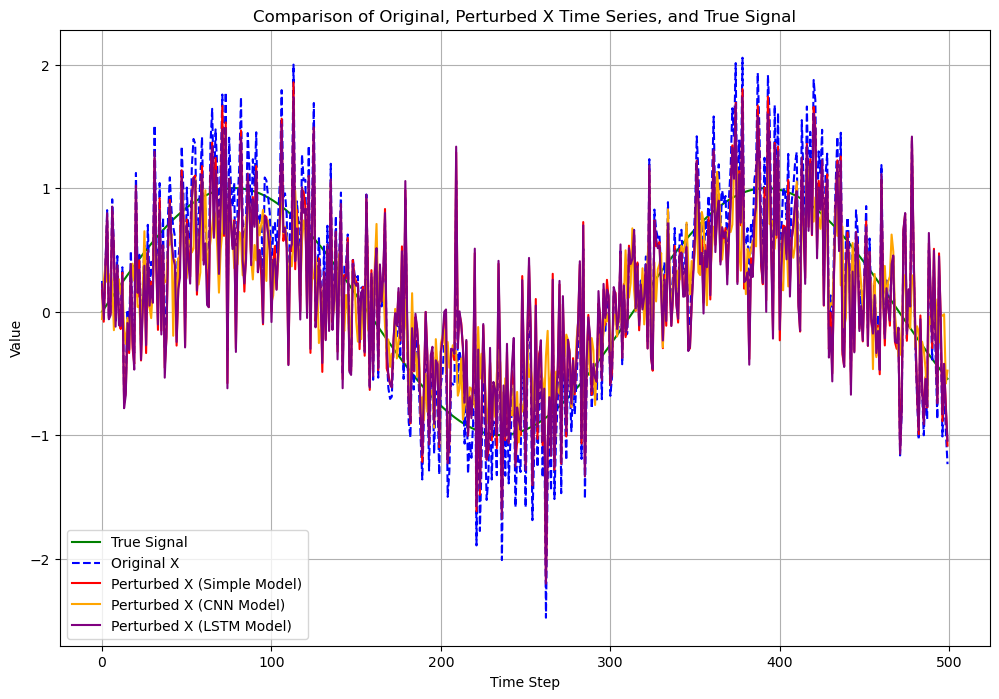

In [28]:
# Initialize each model
simple_model = SimplePerturbationModel(input_dim=time_length, hidden_dim=32, output_dim=time_length)
cnn_model = CNNPerturbationModel(input_dim=time_length, output_dim=time_length)
lstm_model = LSTMPerturbationModel(input_dim=1, hidden_dim=32, output_dim=time_length)

# Train each model
X_perturbed_simple = train_model(simple_model, X_tensor, Y_tensor, Z_tensor)
X_perturbed_cnn = train_model(cnn_model, X_tensor, Y_tensor, Z_tensor)
X_perturbed_lstm = train_model(lstm_model, X_tensor, Y_tensor, Z_tensor)

# Calculate TCA error variances
simple_tca_error = tca_error_variance(X_perturbed_simple, Y_tensor, Z_tensor)
cnn_tca_error = tca_error_variance(X_perturbed_cnn, Y_tensor, Z_tensor)
lstm_tca_error = tca_error_variance(X_perturbed_lstm, Y_tensor, Z_tensor)

print(f"TCA Error Variance - Simple Model: {simple_tca_error:.4f}")
print(f"TCA Error Variance - CNN Model: {cnn_tca_error:.4f}")
print(f"TCA Error Variance - LSTM Model: {lstm_tca_error:.4f}")

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(true_signal, label='True Signal', linestyle='-', color='green')
plt.plot(X_tensor[sample_index].numpy(), label='Original X', linestyle='--', color='blue')
plt.plot(X_perturbed_simple[sample_index].detach().numpy(), label='Perturbed X (Simple Model)', linestyle='-', color='red')
plt.plot(X_perturbed_cnn[sample_index].detach().numpy(), label='Perturbed X (CNN Model)', linestyle='-', color='orange')
plt.plot(X_perturbed_lstm[sample_index].detach().numpy(), label='Perturbed X (LSTM Model)', linestyle='-', color='purple')
plt.title('Comparison of Original, Perturbed X Time Series, and True Signal')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Function to calculate TCA error variance
def tca_error_variance(X, Y, Z):
    tca_error = torch.mean((X - (Y + Z - X) / 2) ** 2)
    return tca_error.item()

# Original TCA error variance
original_tca_error = tca_error_variance(X_tensor, Y_tensor, Z_tensor)

# Perturbed X
X_perturbed = X_tensor + final_Delta_X

# TCA error variance after applying the perturbation
perturbed_tca_error = tca_error_variance(X_perturbed, Y_tensor, Z_tensor)

original_tca_error, perturbed_tca_error

RuntimeError: The size of tensor a (500) must match the size of tensor b (50) at non-singleton dimension 1